In [10]:
def mean_squared_error(y_true, y_pred):
    return 0.5 * np.mean((y_true - y_pred)**2)

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def evaluate(y_pred, y_true, metrics=['loss']):
    y_pred_argmax = np.argmax(y_pred, axis=-1)
    y_true_argmax = np.argmax(y_true, axis=-1)
    ret = []
    for m in metrics:
        if m == 'loss':
            loss = mean_squared_error(y_true, y_pred)
            ret.append(loss)
        elif m == 'accuracy':
            acc = np.sum(y_pred_argmax == y_true_argmax) / len(y_pred)
            ret.append(acc)
        else:
            raise ValueError(
                'an unknown evaluation indicator \'%s\'.' % m
            )
    if len(ret) == 1:
        ret = ret[0]
    elif len(ret) == 0:
        ret = None
    return ret

## load mnist Dataset

In [11]:
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
import time 
n_classes = 10
(x_train, t_train), (x_test, t_test) = mnist.load_data()
# ===============================
# Preprocess
# ===============================
x_train = x_train.astype(np.float32) / 255.
x_train = x_train.reshape(-1, 28**2)
x_test = x_test.astype(np.float32) / 255.
x_test = x_test.reshape(-1, 28**2)
t_train = to_categorical(t_train, n_classes).astype(np.float32)
t_test = to_categorical(t_test, n_classes).astype(np.float32)

# Extreme learning machine

### Generating random weights and biases

In [12]:
def random_weights (n_input_nodes, n_hidden_nodes):
    w = np.random.uniform(-1.,1.,size=(n_input_nodes, n_hidden_nodes))
    bias = np.zeros(shape=(n_hidden_nodes))
    return w, bias

\begin{equation} H = \sum_{i=1}^{\bar{N}}  g\left(\mathbf{w}_{i} \cdot \mathbf{x}_{j}+b_{i}\right)\end{equation}

In [13]:
def compute_H(x,w,b):
    H = sigmoid(x@w + bias)
    return H

\begin{equation}\mathbf{H}^{\dagger}=\textrm{The Moore–Penrose generalized inverse}\end{equation} 

In [14]:
def compute_pinv(H):
    pinv_H = np.linalg.pinv(H)  
    return pinv_H

\begin{equation}\beta=\mathbf{H}^{\dagger} \mathbf{T}\end{equation}

In [15]:
def compute_beta(pinv_H, T):
    beta = pinv_H@T
    return beta

\begin{equation}\mathbf{H} \beta=\mathbf{T}\end{equation}

In [16]:
def compute_target(x, w, bias, beta):
    H = compute_H(x,w,bias)
    t = H@beta
    return t

## NN backpropagation

In [21]:
from keras.models import Sequential
from keras.layers import Dense
def bp_model(n_input_nodes, n_hidden_nodes):
    # Build the model.
    model = Sequential([
      Dense(n_hidden_nodes, input_shape=(n_input_nodes,)),
      Dense(10, activation='sigmoid'),
    ])
    # Compile the model.
    model.compile(
      optimizer='adam',
      loss='mean_squared_error',
      metrics=['mse', 'accuracy'],
    )
    now = time.time()
    # Train the model.
    model.fit(
      x_train,
      t_train,
      epochs=5,
      batch_size=32,
      verbose = 0
    )
    elapsed = time.time()-now
    # evluate model
    score = model.evaluate(x_test, t_test, verbose=0)
    return score[0], score[2], elapsed

## Test models

In [22]:
n_hidden_nodes = [200, 400, 600, 800, 1000]
n_input_nodes = x_train.shape[1]
loss_elm = []
time_elm = []
acc_elm  = []
loss_bp = []
acc_bp = []
time_bp = []
for hidden_nodes in n_hidden_nodes:
    # ELM
    print(hidden_nodes)
    w, bias = random_weights(n_input_nodes, hidden_nodes)
     # fit model
    H=compute_H(x_train, w, bias)
    now = time.time()
    pinv_H = compute_pinv(H)
    elapsed = time.time()-now
    time_elm.append(elapsed)
    beta = compute_beta(pinv_H,t_train)
    
    # test model
    t_pred = compute_target(x_test, w, bias, beta)
    val_loss, val_acc = evaluate(t_pred, t_test, metrics=['loss', 'accuracy'])
    loss_elm.append(val_loss)
    acc_elm.append(val_acc)
    
    # BP
    
    val_loss, val_acc, val_time = bp_model(n_input_nodes, hidden_nodes)
    loss_bp.append(val_loss)
    acc_bp.append(val_acc)
    time_bp.append(val_time)

200
400
600
800
1000


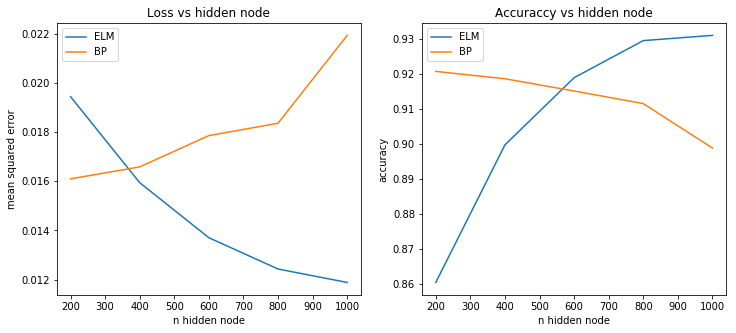

In [37]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(n_hidden_nodes, loss_elm, label="ELM")
ax1.plot(n_hidden_nodes, loss_bp, label="BP")
ax1.set_label('Label via method')
ax1.set(xlabel='n hidden node', ylabel='mean squared error')
ax1.set_title("Loss vs hidden node")
ax1.legend()
ax2.plot(n_hidden_nodes, acc_elm, label="ELM")
ax2.plot(n_hidden_nodes, acc_bp, label="BP")
ax2.set(xlabel='n hidden node', ylabel='accuracy')
ax2.set_title("Accuraccy vs hidden node")
ax2.legend()
plt.show()

se observa que el ELM a mas nodo ocultos obtiene una mejor exactitud con respecto al metodo back propagation 

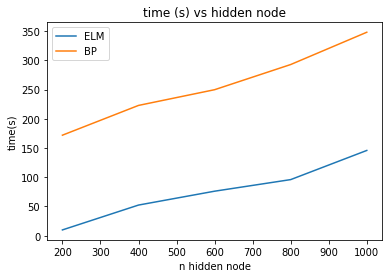

In [39]:
plt.plot(n_hidden_nodes, time_elm, label = 'ELM')
plt.plot(n_hidden_nodes, time_bp, label='BP')
plt.ylabel('time(s)')
plt.xlabel('n hidden node')
plt.title('time (s) vs hidden node')
plt.legend()
plt.show()

El modelo ELM usa menos tiempo a la hora del entrenamiento, ya que no depende de un metodo iterativo, si no del calculado de la pseudo inversa.